In [361]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pgeocode

In [362]:
import warnings
warnings.filterwarnings('ignore')

In [363]:
df = pd.read_csv('redfin_cleaned_stage_1.csv', low_memory = False)
df_income = pd.read_csv('per_cap_income.csv')

In [364]:
df_income = df_income.dropna()
na_count = df.isna().sum()

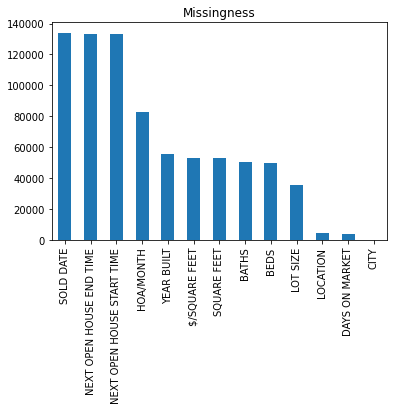

In [365]:
na_count.sort_values(ascending=False).head(13).plot.bar();
plt.title('Missingness');

In [366]:
df = df.drop(['SOLD DATE','NEXT OPEN HOUSE END TIME','NEXT OPEN HOUSE START TIME','HOA/MONTH',
             'URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)','FAVORITE',
             'INTERESTED','SOURCE','ZIP OR POSTAL CODE'],axis=1)

In [367]:
df['BEDS'] = df['BEDS'].astype(str)

In [368]:
df.BEDS = df.BEDS.dropna()
df = df[df.BEDS != 'nan']
df['BEDS'] = df['BEDS'].astype(float)
df['BEDS'] = df['BEDS'].astype(int)
df = df[df.BEDS < 12]

In [369]:
# df.BEDS.value_counts()

In [370]:
df['BATHS'] = df['BATHS'].astype(str)
df.BATHS = df.BATHS.dropna()
df = df[df.BATHS != 'nan']
df['BATHS'] = df['BATHS'].astype(float)
df['BATHS'] = df['BATHS'].astype(int)
df = df[df.BATHS < 10]

In [371]:
categorical_a = df[['BATHS','BEDS','STATE OR PROVINCE','PROPERTY TYPE']]

myVars = df[['Unnamed: 0', 'SALE TYPE', 'PROPERTY TYPE', 'ADDRESS',
       'CITY', 'STATE OR PROVINCE', 'PRICE', 'BEDS',
       'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
       'DAYS ON MARKET', '$/SQUARE FEET', 'STATUS','MLS#','LATITUDE', 'LONGITUDE',
       'zip']]

In [372]:
df['YEAR BUILT'] = df['YEAR BUILT'].astype(str)
df['YEAR BUILT'] = df['YEAR BUILT'].dropna()
df = df[df['YEAR BUILT'] != 'nan']
df['YEAR BUILT'] = df['YEAR BUILT'].astype(float)
df['YEAR BUILT'] = df['YEAR BUILT'].astype(int)
df = df[df['YEAR BUILT'] > 1990]

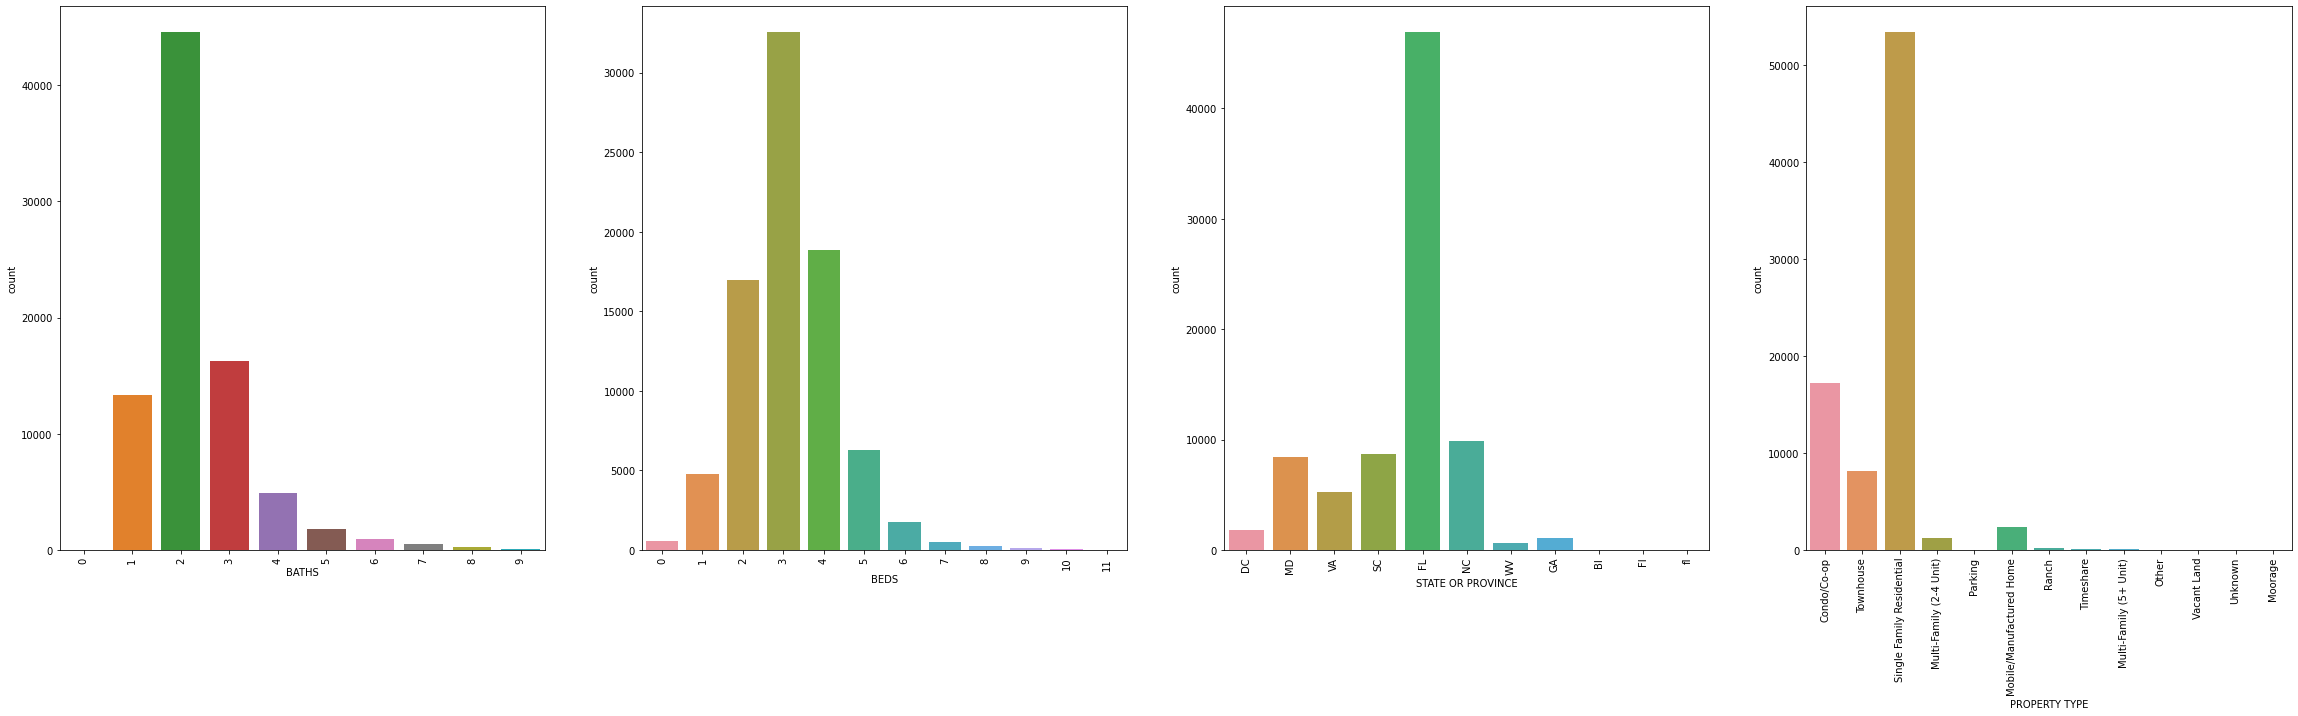

In [373]:
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
for variable, subplot in zip(categorical_a, ax.flatten()):
    sns.countplot(x=myVars[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

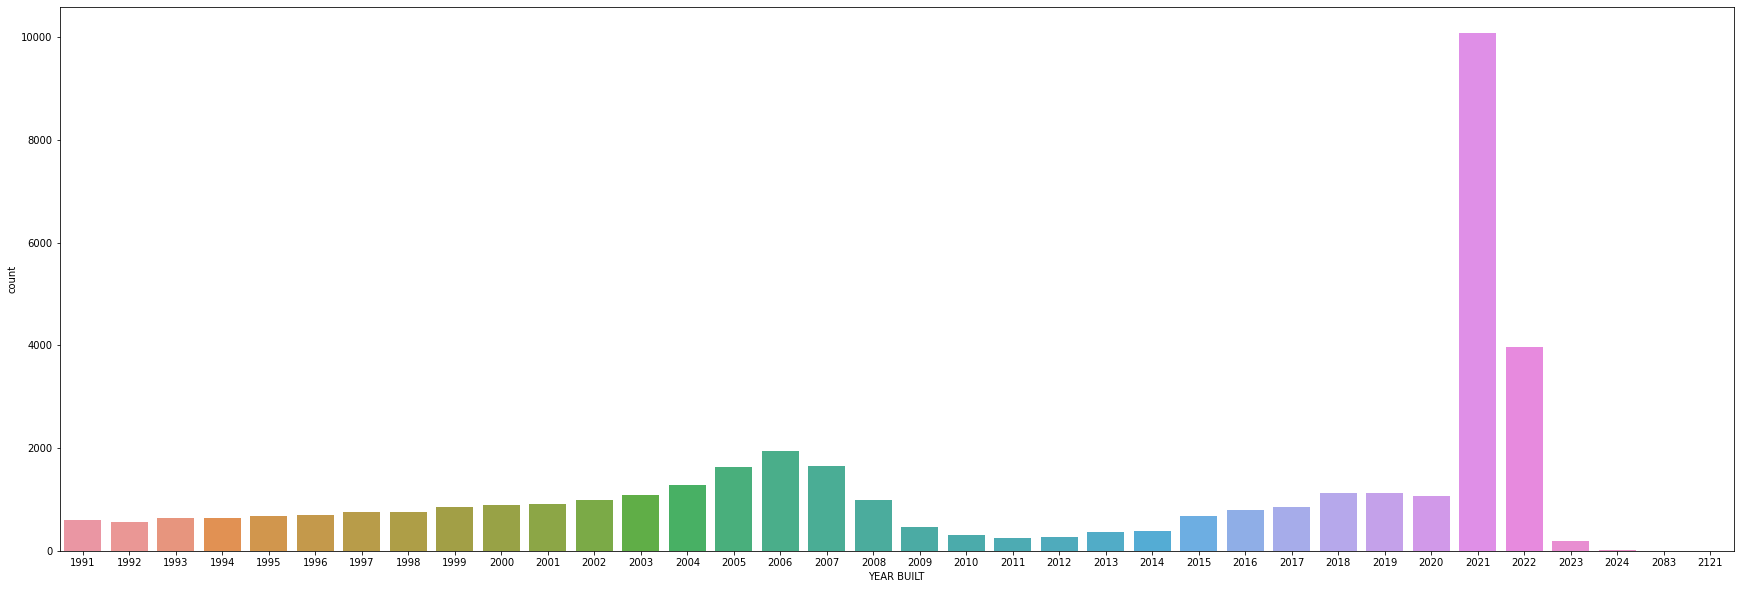

In [374]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.countplot(x="YEAR BUILT", data=df)

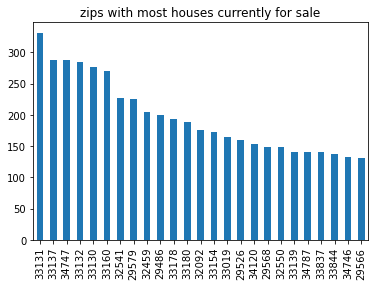

In [375]:
df.zip.value_counts()[0:25].plot.bar();
plt.title('zips with most houses currently for sale');

In [376]:
data = pgeocode.Nominatim('US')
data.query_postal_code("33131")

postal_code            33131
country_code              US
place_name             Miami
state_name           Florida
state_code                FL
county_name       Miami-Dade
county_code             86.0
community_name           NaN
community_code           NaN
latitude             25.7629
longitude           -80.1895
accuracy                 4.0
Name: 0, dtype: object

In [377]:
data = pgeocode.Nominatim('US')
data.query_postal_code("33131")['state_code']

'FL'

**Create list of all zip codes in redfin data csv** <br>
**This is to feed into pgeocode package to extract county_name**

In [378]:
redfin_zip_list = []
for single_zip in df.zip.unique() :
    redfin_zip_list.append(single_zip.astype(str))

In [379]:
counties = []
for single_zip in redfin_zip_list :
    counties.append(data.query_postal_code(single_zip)['county_name'])

In [380]:
states = []
for single_zip in redfin_zip_list :
    states.append(data.query_postal_code(single_zip)['state_code'])

In [381]:
zips_counties = pd.DataFrame(redfin_zip_list, columns = ['zipcode'])

In [382]:
if len(states) == len(counties) :
    print('lists are equal')
else : print('lists are unequal')

lists are equal


In [383]:
zips_counties['county_name'] = counties
zips_counties['state_name'] = states

<h4>Merge income data with the zipcode/county/state data... <br>
    ...some counties are named the same... 🚧 <br> so need to merge by <b>both</b> 
county and state name 🖇</h4>

In [384]:
zips_counties

,zipcode,county_name,state_name
0,20001,District of Columbia,DC
1,20002,District of Columbia,DC
2,20003,District of Columbia,DC
3,20004,District of Columbia,DC
4,20005,District of Columbia,DC
...,...,...,...
2158,34987,St. Lucie,FL
2159,34990,Martin,FL
2160,34994,Martin,FL
2161,34996,Martin,FL


In [385]:
df_income.head(3)

,Unnamed: 0,Unnamed: 0.1,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,PRICE,BEDS,BATHS,...,STATUS,MLS#,LATITUDE,LONGITUDE,zip,state_code,county_code,per_cap_income,rank_in_state,zipcode
5,5,159,MLS Listing,Townhouse,144 S St NW,Washington,DC,1299900.0,4,4,...,Active,DCDC2019602,38.913864,-77.013625,20001,DC,District of Columbia,"86,567",--,20001
26,26,2395,MLS Listing,Townhouse,150-A S St NW,Washington,DC,1299900.0,3,3,...,Active,DCDC525210,38.913900,-77.013860,20001,DC,District of Columbia,"86,567",--,20001
44,44,10745,For-Sale-by-Owner Listing,Condo/Co-op,1011 M St NW Apt 208,Washington,DC,689000.0,2,2,...,Active,11452332,38.905983,-77.026625,20001,DC,District of Columbia,"86,567",--,20001


In [386]:
new_df = pd.merge(df_income, zips_counties,  how='right', left_on=['state_code','county_code'], right_on = ['state_name','county_name'])

In [387]:
new_df = new_df.drop(['county_name','state_name'],axis=1)

In [388]:
new_df = new_df.dropna()

In [389]:
new_df.head(3)

,Unnamed: 0,Unnamed: 0.1,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,PRICE,BEDS,BATHS,...,MLS#,LATITUDE,LONGITUDE,zip,state_code,county_code,per_cap_income,rank_in_state,zipcode_x,zipcode_y
0,5.0,159.0,MLS Listing,Townhouse,144 S St NW,Washington,DC,1299900.0,4.0,4.0,...,DCDC2019602,38.913864,-77.013625,20001.0,DC,District of Columbia,"86,567",--,20001.0,20001
1,26.0,2395.0,MLS Listing,Townhouse,150-A S St NW,Washington,DC,1299900.0,3.0,3.0,...,DCDC525210,38.913900,-77.013860,20001.0,DC,District of Columbia,"86,567",--,20001.0,20001
2,44.0,10745.0,For-Sale-by-Owner Listing,Condo/Co-op,1011 M St NW Apt 208,Washington,DC,689000.0,2.0,2.0,...,11452332,38.905983,-77.026625,20001.0,DC,District of Columbia,"86,567",--,20001.0,20001


In [390]:
df.head(3)

,Unnamed: 0,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,STATUS,MLS#,LATITUDE,LONGITUDE,zip
0,10730,MLS Listing,Condo/Co-op,810 O St NW #201,Washington,DC,899900.0,2,2,OLD CITY II,1282.0,NaN,2019,250.0,702.0,Active,DCDC514770,38.908332,-77.023611,20001
8,1962,MLS Listing,Condo/Co-op,2250 11th St NW #206,Washington,DC,499900.0,1,1,OLD CITY II,675.0,NaN,2009,60.0,741.0,Active,DCDC2000435,38.920439,-77.027289,20001
9,625,MLS Listing,Condo/Co-op,912 U St NW #505,Washington,DC,539900.0,1,1,SHAW,660.0,NaN,2021,8.0,818.0,Active,DCDC2022458,38.916750,-77.024553,20001


In [393]:
new_df['zip'] = new_df['zip'].astype(int)

In [394]:
df = df.merge(new_df, left_on='zip',right_on='zip')

In [359]:
df.to_csv('per_cap_income.csv')

In [358]:

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["State", "Unemployment"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unemployment Rate (%)",
).add_to(m)

folium.LayerControl().add_to(m)


FL    21957
NC     5362
SC     4900
MD     2461
VA     1594
DC      520
GA      507
WV      357
Fl        3
BI        1
Name: STATE OR PROVINCE, dtype: int64
FL    21961
NC     5361
SC     4899
MD     2461
VA     1595
DC      520
GA      506
WV      359
Name: state_code, dtype: int64
